In [81]:
import numpy as np
import pandas as pd
import pickle
#import seaborn as sns
import matplotlib.pyplot as plt

In [82]:
#Retrieve pickle object
fileObj = open('data_algos.pkl', 'rb')
all_generations = pickle.load(fileObj)
fileObj.close()

In [83]:
#creating one DataFrame for each selection method
generations_df = pd.DataFrame(all_generations)
#checking the results
generations_df.sample(5)

,radius,generation,fitness,selection_type,pop_size,mutation
367304,1.882353,420,0.018471,Ranked Selection,65,0.000
1015660,1.647059,226,0.018701,Ranked Selection,25,0.001
1218740,1.882353,170,0.018471,Ranked Selection,95,0.001
1029344,1.647059,195,0.018701,Ranked Selection,35,0.001
836122,1.529412,429,0.018543,Random Selection,55,0.001


In [84]:
#Sample Statistics
generations_df.groupby(by=['selection_type', 'generation']).describe(percentiles = [0.5])


radius                                            \
                              count       mean       std       min        50%   
selection_type   generation                                                     
Random Selection 0           1000.0  15.674824  8.511179  0.117647  16.235294   
                 1           1000.0  15.289294  8.368520  0.117647  15.647059   
                 2           1000.0  15.176000  8.314857  0.117647  15.647059   
                 3           1000.0  14.557882  8.248599  0.117647  14.823529   
                 4           1000.0  13.750706  8.318276  0.117647  12.941176   
...                             ...        ...       ...       ...        ...   
Wheel Selection  495         1000.0   1.803294  0.543445  1.411765   1.882353   
                 496         1000.0   1.802471  0.477340  1.411765   1.882353   
                 497         1000.0   1.807529  0.696671  0.470588   1.882353   
                 498         1000.0   1.797176  0.544303  1.411765   1.882353   
                 499         1000.0   1.772706  0.189407  1.411765   1.882353   

                                       fitness                                \
                                   max   count      mean       std       min   
selection_type   generation                                                    
Random Selection 0           30.000000  1000.0  0.002602  0.004444  0.000177   
                 1           30.000000  1000.0  0.002621  0.004430  0.000177   
                 2           30.000000  1000.0  0.002596  0.004348  0.000177   
                 3           30.000000  1000.0  0.002832  0.004585  0.000177   
                 4           30.000000  1000.0  0.003312  0.005054  0.000177   
...                                ...     ...       ...       ...       ...   
Wheel Selection  495         16.588235  1000.0  0.018385  0.001016  0.000577   
                 496          9.411765  1000.0  0.018377  0.001097  0.001776   
                 497         16.470588  1000.0  0.018388  0.001058  0.000585   
                 498         16.941176  1000.0  0.018402  0.000914  0.000553   
                 499          2.470588  1000.0  0.018451  0.000362  0.015965   

                             ... pop_size                  mutation          \
                             ...      std  min   50%   max    count    mean   
selection_type   generation  ...                                              
Random Selection 0           ...  23.5224  5.0  75.0  95.0   1000.0  0.0005   
                 1           ...  23.5224  5.0  75.0  95.0   1000.0  0.0005   
                 2           ...  23.5224  5.0  75.0  95.0   1000.0  0.0005   
                 3           ...  23.5224  5.0  75.0  95.0   1000.0  0.0005   
                 4           ...  23.5224  5.0  75.0  95.0   1000.0  0.0005   
...                          ...      ...  ...   ...   ...      ...     ...   
Wheel Selection  495         ...  23.5224  5.0  75.0  95.0   1000.0  0.0005   
                 496         ...  23.5224  5.0  75.0  95.0   1000.0  0.0005   
                 497         ...  23.5224  5.0  75.0  95.0   1000.0  0.0005   
                 498         ...  23.5224  5.0  75.0  95.0   1000.0  0.0005   
                 499         ...  23.5224  5.0  75.0  95.0   1000.0  0.0005   

                                                         
                                std  min     50%    max  
selection_type   generation                              
Random Selection 0           0.0005  0.0  0.0005  0.001  
                 1           0.0005  0.0  0.0005  0.001  
                 2           0.0005  0.0  0.0005  0.001  
                 3           0.0005  0.0  0.0005  0.001  
                 4           0.0005  0.0  0.0005  0.001  
...                             ...  ...     ...    ...  
Wheel Selection  495         0.0005  0.0  0.0005  0.001  
                 496         0.0005  0.0  0.0005  0.001  
                 497        

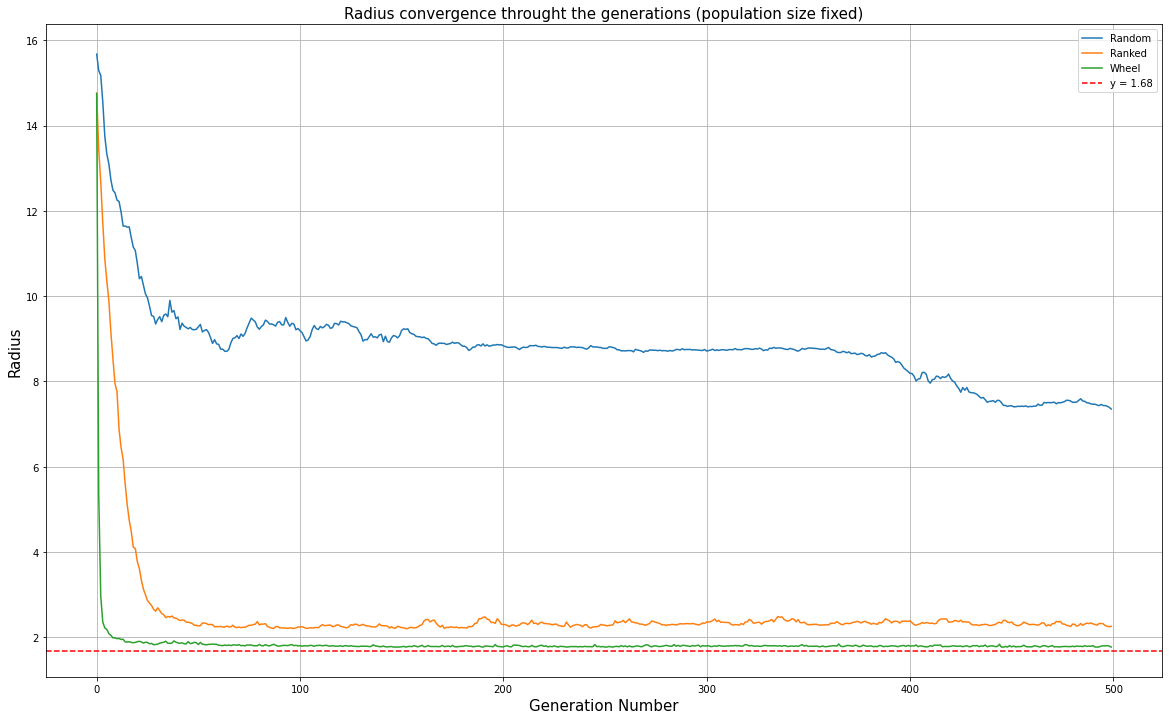

In [85]:
grouped = generations_df.groupby(by=['selection_type', 'generation']).mean()
#create plots

plt.rcParams["figure.figsize"]=(20,12)

x1 = range(len(grouped.loc['Random Selection', 'fitness']))
y1 = grouped.loc['Random Selection', 'radius']
y2 = grouped.loc['Ranked Selection', 'radius']
y3 = grouped.loc['Wheel Selection', 'radius']

plt.title('Radius convergence throught the generations (population size fixed)',fontsize=15)
plt.xlabel('Generation Number',fontsize=15)
plt.ylabel('Radius',fontsize=15)

plt.plot(x1,y1,label = 'Random')
plt.plot(x1,y2,label = 'Ranked') 
plt.plot(x1,y3, label = 'Wheel')  
plt.grid()
plt.axhline(y=1.6841, color='r', linestyle='--', label='y = 1.68')
plt.legend()

plt.show()

In [86]:
grouped.loc['Random Selection', 'radius']

generation
0      15.674824
1      15.289294
2      15.176000
3      14.557882
4      13.750706
         ...    
495     7.437529
496     7.435412
497     7.420235
498     7.395529
499     7.354706
Name: radius, Length: 500, dtype: float64

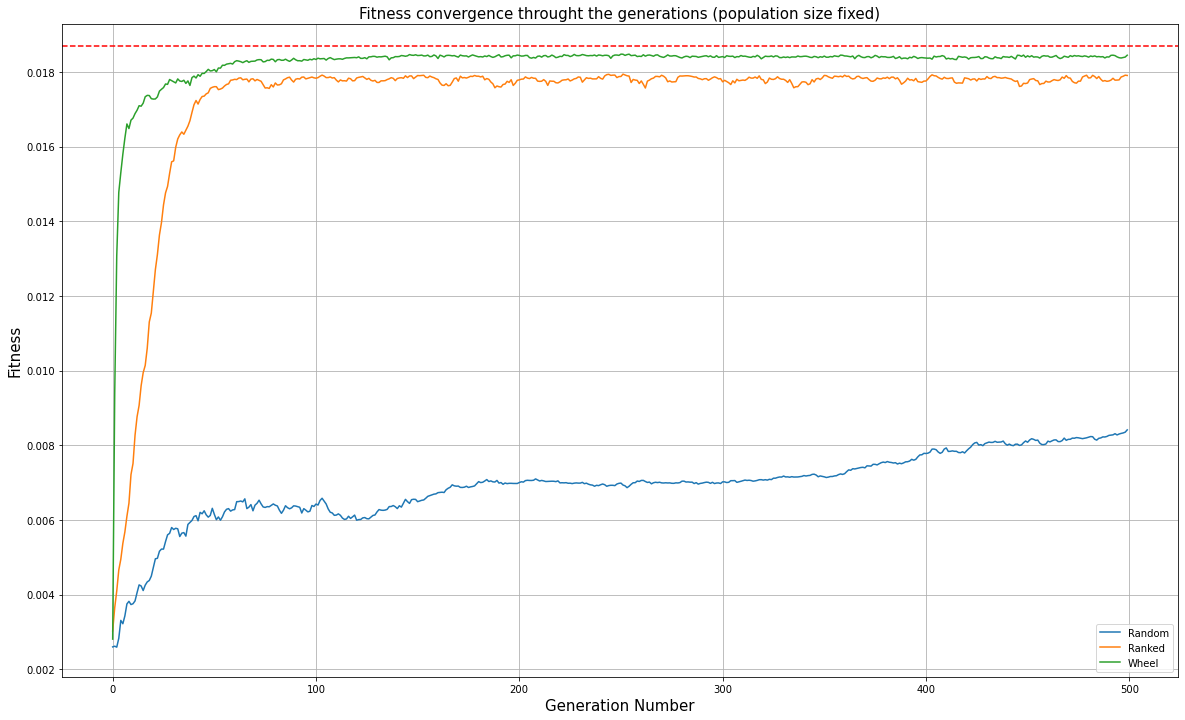

In [87]:
grouped = generations_df.groupby(by=['selection_type', 'generation']).mean()
#create plots

plt.rcParams["figure.figsize"]=(20,12)

x1 = range(len(grouped.loc['Random Selection', 'fitness']))
y1 = grouped.loc['Random Selection', 'fitness']
y2 = grouped.loc['Ranked Selection', 'fitness']
y3 = grouped.loc['Wheel Selection', 'fitness']

plt.title('Fitness convergence throught the generations (population size fixed)',fontsize=15)
plt.xlabel('Generation Number',fontsize=15)
plt.ylabel('Fitness',fontsize=15)

plt.plot(x1,y1,label = 'Random')
plt.plot(x1,y2,label = 'Ranked') 
plt.plot(x1,y3, label = 'Wheel')  
plt.grid()
plt.legend()
plt.axhline(y=0.018709891942760622, color='r', linestyle='--', label='y = 0,0187')

plt.show()

In [88]:
generations_df.groupby(by=['selection_type', 'pop_size']).describe(percentiles = [0.5])

radius                                             \
                             count       mean        std       min        50%   
selection_type   pop_size                                                       
Random Selection 5          5000.0  10.172141   5.405817  0.117647  10.588235   
                 15        15000.0   7.259969   5.679471  0.117647  12.411765   
                 25        25000.0   7.150428   2.058677  0.117647   6.000000   
                 35        35000.0   2.827849   2.449945  0.117647   3.764706   
                 45        45000.0   9.109558   7.018011  0.117647  13.647059   
                 55        55000.0   1.804798   2.594998  0.117647   1.058824   
                 65        65000.0  12.367739   4.436779  0.117647  14.352941   
                 75        75000.0  13.083947  10.571189  0.117647  11.176471   
                 85        85000.0   9.367246   6.164995  0.117647   8.117647   
                 95        95000.0   9.387377   5.987901  0.117647   6.000000   
Ranked Selection 5          5000.0   9.566282  10.349121  0.470588  11.294118   
                 15        15000.0  13.443733   9.384656  0.470588  22.588235   
                 25        25000.0   2.107501   2.330137  0.235294   1.882353   
                 35        35000.0   1.993916   1.815523  0.117647   1.882353   
                 45        45000.0   2.018842   1.714340  0.117647   1.882353   
                 55        55000.0   2.236776   1.764920  0.117647   2.117647   
                 65        65000.0   2.343061   2.500534  0.117647   1.882353   
                 75        75000.0   2.033758   2.453335  0.117647   1.647059   
                 85        85000.0   2.132728   2.294429  0.117647   1.882353   
                 95        95000.0   2.239622   2.077900  0.117647   1.882353   
Wheel Selection  5          5000.0   1.798894   0.941398  0.588235   2.000000   
                 15        15000.0   2.078110   0.928334  0.117647   2.470588   
                 25        25000.0   1.769393   0.894742  0.117647   1.882353   
                 35        35000.0   1.647892   0.863402  0.235294   1.647059   
                 45        45000.0   1.741895   0.867476  0.117647   1.882353   
                 55        55000.0   1.978511   0.916036  0.117647   1.882353   
                 65        65000.0   1.674766   0.892733  0.117647   1.647059   
                 75        75000.0   1.880331   0.831801  0.117647   1.882353   
                 85        85000.0   1.854260   0.891770  0.117647   1.882353   
                 95        95000.0   1.952073   0.869500  0.117647   1.882353   

                                     generation                          ...  \
                                 max      count   mean         std  min  ...   
selection_type   pop_size                                                ...   
Random Selection 5         26.823529     5000.0  249.5  144.351715  0.0  ...   
                 15        28.823529    15000.0  249.5  144.342090  0.0  ...   
                 25        30.000000    25000.0  249.5  144.340165  0.0  ...   
                 35        29.882353    35000.0  249.5  144.339341  0.0  ...   
                 45        30.000000    45000.0  249.5  144.338882  0.0  ...   
                 55        29.647059    55000.0  249.5  144.338591  0.0  ...   
                 65        30.000000    65000.0  249.5  144.338389  0.0  ...   
                 75        29.882353    75000.0  249.5  144.338241  0.0  ...   
                 85        30.000000    85000.0  249.5  144.338128  0.0  ...   
                 95        30.000000    95000.0  249.5  144.338038  0.0  ...   
Ranked Selection 5         29.529412     5000.0  249.5  144.351715  0.0  ...   
                 15        29.882353    15000.0  249.5  144.342090  0.0  ...   
                 25        29.764706    25000.0  249.5  144.340165  0.0  ...   
                 35        29.764706    35000.0  249.5  144.339341  0.0  .

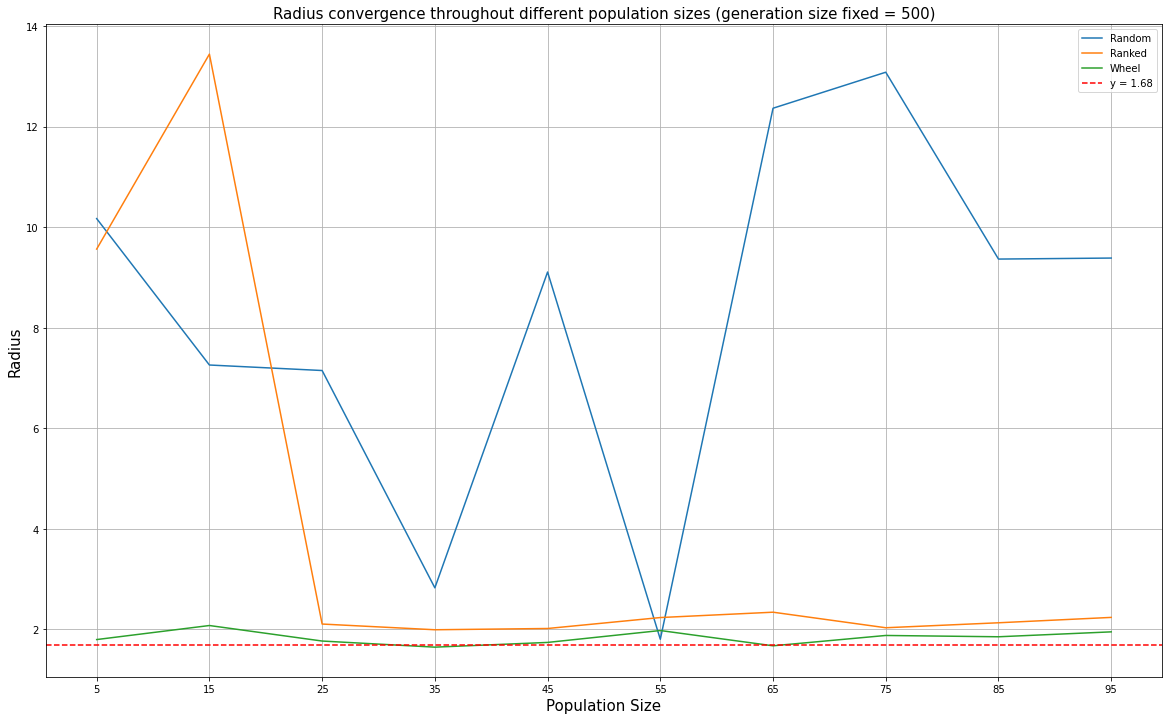

In [89]:
grouped_pop = generations_df.groupby(by=['selection_type', 'pop_size']).mean()
#create plots

plt.rcParams["figure.figsize"]=(20,12)

x1 = range(len(grouped_pop.loc['Random Selection', 'radius']))
y1 = grouped_pop.loc['Random Selection', 'radius']
y2 = grouped_pop.loc['Ranked Selection', 'radius']
y3 = grouped_pop.loc['Wheel Selection', 'radius']

plt.title('Radius convergence throughout different population sizes (generation size fixed = 500)',fontsize=15)
plt.xlabel('Population Size',fontsize=15)
plt.ylabel('Radius',fontsize=15)

plt.plot(x1,y1,label = 'Random')
plt.plot(x1,y2,label = 'Ranked') 
plt.plot(x1,y3, label = 'Wheel')  

plt.grid()
plt.axhline(y=1.6841, color='r', linestyle='--', label='y = 1.68')
plt.legend()

plt.xticks(range(len(grouped_pop.loc['Random Selection', 'radius'])), labels=grouped_pop.loc['Random Selection', 'radius'].index)
plt.show()

In [90]:
grouped_pop.loc['Random Selection', 'radius'].values

array([10.17214118,  7.25996863,  7.15042824,  2.82784874,  9.10955817,
        1.80479786, 12.36773937, 13.08394667,  9.36724567,  9.38737709])

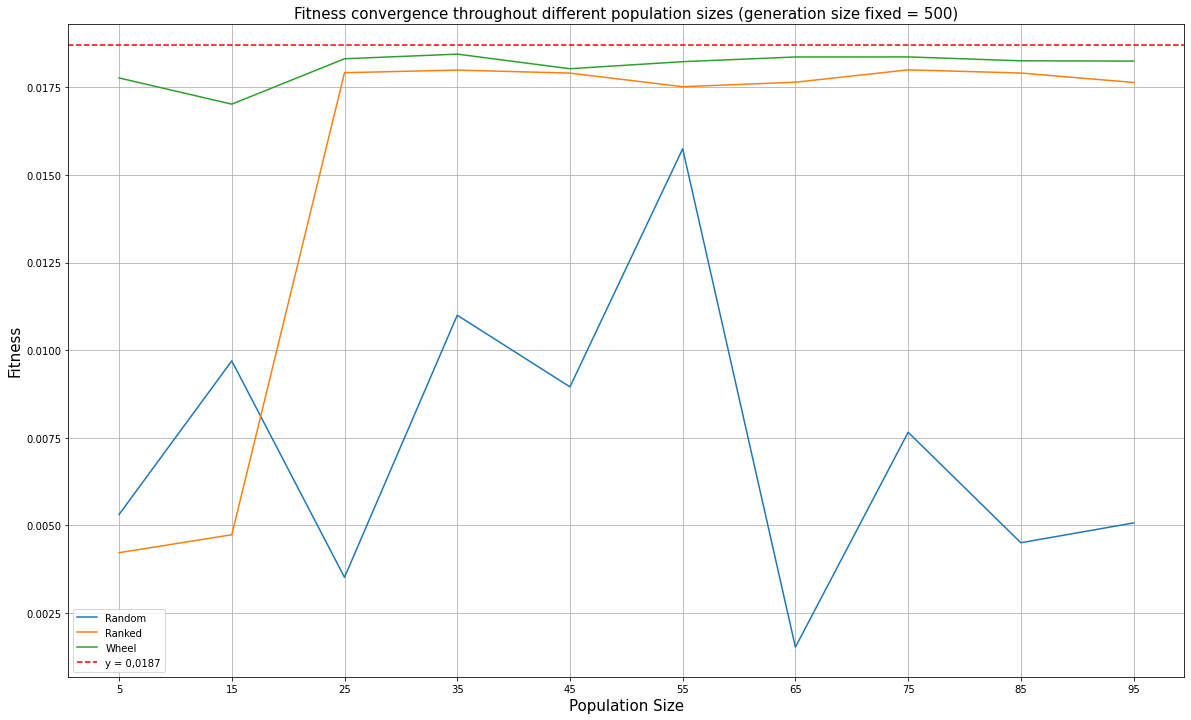

In [91]:
grouped_pop = generations_df.groupby(by=['selection_type', 'pop_size']).mean()
#create plots

plt.rcParams["figure.figsize"]=(20,12)

x1 = range(len(grouped_pop.loc['Random Selection', 'fitness']))
y1 = grouped_pop.loc['Random Selection', 'fitness']
y2 = grouped_pop.loc['Ranked Selection', 'fitness']
y3 = grouped_pop.loc['Wheel Selection', 'fitness']

plt.title('Fitness convergence throughout different population sizes (generation size fixed = 500)',fontsize=15)
plt.xlabel('Population Size',fontsize=15)
plt.ylabel('Fitness',fontsize=15)

plt.plot(x1,y1,label = 'Random')
plt.plot(x1,y2,label = 'Ranked') 
plt.plot(x1,y3, label = 'Wheel')  
plt.grid()
plt.axhline(y=0.018709891942760622, color='r', linestyle='--', label='y = 0,0187')
plt.xticks(range(len(grouped_pop.loc['Random Selection', 'radius'])), labels=grouped_pop.loc['Random Selection', 'radius'].index)
plt.legend()

plt.show()